# Inspecting similarity of feature outputs depending on image transforms
Heatmaps will be generated presenting cosine similarity between feature outputs. Model outputs are dependent on image preprocessing

### Code

In [14]:
import torch
from torchvision import models
import torchvision.transforms as transforms

import numpy as np
import pandas as pd

from utils import load_image_into_resnet_tensor,load_img,ResnetFeatureExtractor
from matplotlib import pyplot as plt
import seaborn as sns


In [15]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [16]:
resnet = models.resnet50(pretrained=True).to(device)
resnet.eval()
model = ResnetFeatureExtractor(resnet)

/home/milte/anaconda3/envs/torch-cv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/milte/anaconda3/envs/torch-cv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
im1_path = "/home/milte/Desktop/AI-nspired/data/Inspiracje_WEB/1B_3.JPG"
im2_path = "/home/milte/Desktop/AI-nspired/data/Inspiracje_WEB/1B_9.JPG"

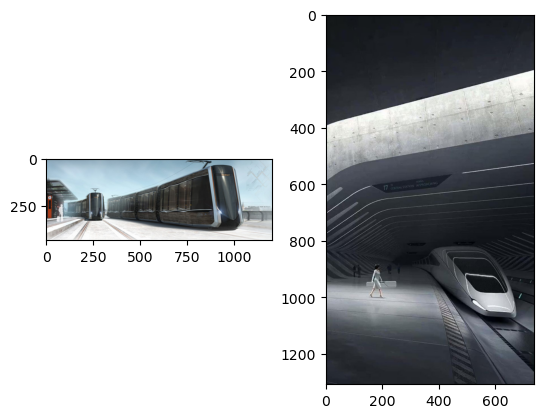

In [18]:
plt.subplot(1,2,1)
plt.imshow(load_img(im1_path))
plt.subplot(1,2,2)
plt.imshow(load_img(im2_path))
plt.show()

In [19]:
class ResultContainer:
    def __init__(self,name,tensor1,tensor2) -> None:
        self.name = name
        self.tensor1 = tensor1.cpu().detach()
        self.tensor2 = tensor2.cpu().detach()

In [20]:
def do_transform(name,transform) -> ResultContainer:
    pipeline = transforms.Compose([*transform,transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])
    im1_tensor = load_image_into_resnet_tensor(im1_path,pipeline,device)
    im2_tensor = load_image_into_resnet_tensor(im2_path,pipeline,device)
    
    im1_features = model(im1_tensor)
    im2_features = model(im2_tensor)
    
    return ResultContainer(name,im1_features,im2_features)

In [21]:
all_transforms = {
    "original": [],
    "squash": [transforms.Resize((224,224))],
    "keep_ratio_resize": [transforms.Resize(224)],
    "resnet_original": [transforms.Resize(232),transforms.CenterCrop(224)]
}

In [22]:
results = {}
for key,transform in all_transforms.items():
    result = do_transform(key,transform)
    results[key] = result

In [23]:
def make_heatmap(results,map_function,plotname):
    df = pd.DataFrame({key:[0]*len(results) for key in results.keys()},index=results.keys())
    for key1,result1 in results.items():
        for key2,result2 in results.items():
            v = map_function(result1,result2)
            df.loc[key1,key2] = v
    sns.heatmap(df,annot=True)
    plt.title(plotname)
    plt.show()
            

## Heatmaps

/tmp/ipykernel_3696/3694525124.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9999998807907104' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[key1,key2] = v
/tmp/ipykernel_3696/3694525124.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9202184081077576' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[key1,key2] = v
/tmp/ipykernel_3696/3694525124.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9657720327377319' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[key1,key2] = v
/tmp/ipykernel_3696/3694525124.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and w

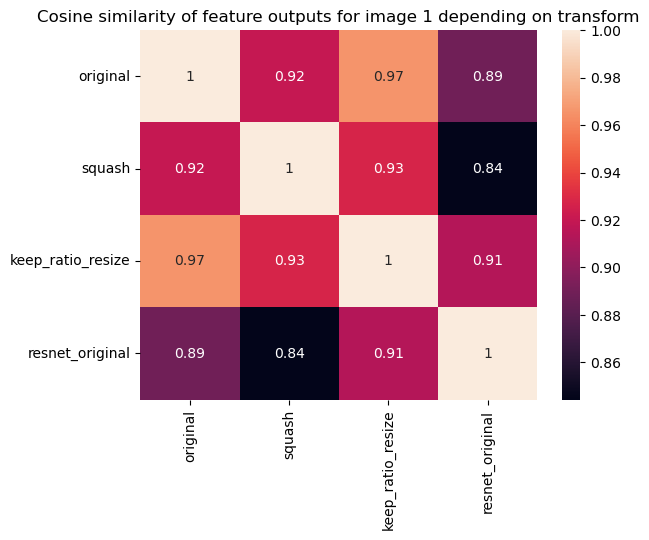

In [24]:
make_heatmap(
    results,
    lambda r1,r2: torch.nn.functional.cosine_similarity(r1.tensor1,r2.tensor1).item(),
    "Cosine similarity of feature outputs for image 1 depending on transform")

/tmp/ipykernel_3696/3694525124.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9999997615814209' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[key1,key2] = v
/tmp/ipykernel_3696/3694525124.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.833387017250061' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[key1,key2] = v
/tmp/ipykernel_3696/3694525124.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8737404346466064' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[key1,key2] = v
/tmp/ipykernel_3696/3694525124.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and wi

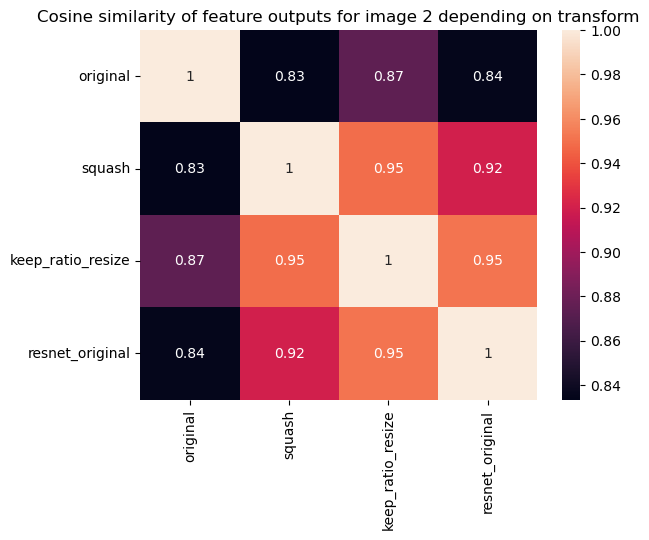

In [25]:
make_heatmap(
    results,
    lambda r1,r2: torch.nn.functional.cosine_similarity(r1.tensor2,r2.tensor2).item(),
    "Cosine similarity of feature outputs for image 2 depending on transform")

/tmp/ipykernel_3696/3694525124.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.7734472751617432' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[key1,key2] = v


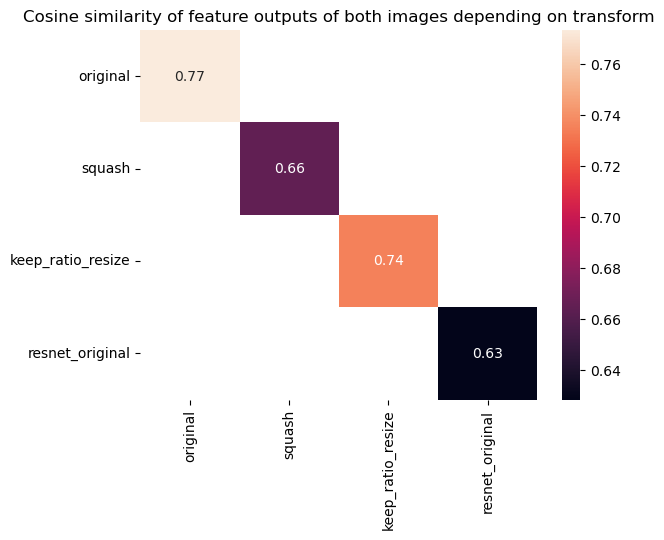

In [28]:
make_heatmap(
    results,
    lambda r1,r2: torch.nn.functional.cosine_similarity(r1.tensor1,r2.tensor2).item() if r1.name == r2.name else np.nan,
    "Cosine similarity of feature outputs of both images depending on transform")